In [13]:
from excited_workflow.train_models import carbon_tracker
from pathlib import Path

In [14]:
from dask.distributed import Client
client = Client()

In [15]:
cb_path = Path("/data/volume_2/EXCITED_prepped_data/CT2022.flux1x1-monthly.nc")
ds_regions = Path("/data/volume_2/EXCITED_prepped_data/regions.nc")

desired_data = [
    "biomass",
    "spei",
    "modis",
    "era5_monthly",
    "era5_land_monthly",
    "copernicus_landcover"
    ]

x_keys = ["d2m", "mslhf", "msshf", "ssr", "str", "t2m", "spei", "NIRv", "skt", "stl1", "swvl1", "lccs_class"]
y_key = "bio_flux_opt"



In [16]:
from pathlib import Path

import numpy as np
import pandas as pd
import pycaret.regression
import xarray as xr
import xarray_regrid  # Importing this will make Dataset.regrid accessible.
from dask.distributed import Client
from pycaret.classification import predict_model

import excited_workflow
from excited_workflow.source_datasets import datasets

In [17]:
def merge_datasets(desired_data: list[str], target: Path) -> xr.Dataset:
    """Merge datasets onto one common grid.
    
    Args:
        desired_data: list of desired datasets
        freq: time frequency that is desired
        target: target grid dataset

    Returns:
        Dataset of input variables.
    """
    ds_cb = xr.open_dataset(target)
    ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)
    ds_input = xr.merge([datasets[name].load(freq="monthly", target_grid=ds_cb) 
                         for name in desired_data])
    
    return ds_input

In [18]:
ds_input = merge_datasets(desired_data, cb_path)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

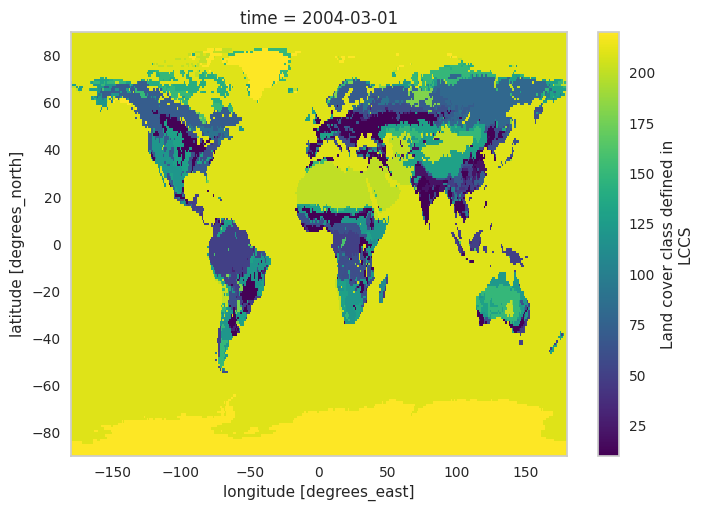

In [37]:
ds_input["lccs_class"].isel(time=170).plot()

In [20]:
def mask_region(regions: Path,  
                target: Path, 
                ds_input: xr.Dataset
                ) -> xr.Dataset:
    """Limit data to a region and time slice."""
    ds_regions = xr.open_dataset(regions)
    ds_cb = xr.open_dataset(target)
    ds_merged = xr.merge([
        ds_cb[["bio_flux_opt"]], 
        ds_regions["transcom_regions"],
        ds_input,
        ])
    time_region_na = {"time": slice("2000-01", "2019-12"), 
                      "latitude": slice(15, 60), 
                      "longitude": slice(-140, -55),
                      }
    ds_na = ds_merged.sel(time_region_na)
    ds_na = ds_na.compute()
    ds_na = ds_na.where(ds_merged["transcom_regions"]==2)

    return ds_na

In [21]:
ds_na = mask_region(ds_regions, cb_path, ds_input)

In [22]:
ds_na

<xarray.Dataset>
Dimensions:           (longitude: 85, latitude: 45, time: 480)
Coordinates:
  * longitude         (longitude) float64 -139.5 -138.5 -137.5 ... -56.5 -55.5
  * latitude          (latitude) float64 15.5 16.5 17.5 18.5 ... 57.5 58.5 59.5
  * time              (time) datetime64[ns] 2000-01-01 ... 2019-12-16T12:00:00
Data variables: (12/26)
    bio_flux_opt      (time, latitude, longitude) float64 nan nan ... 0.0 0.0
    transcom_regions  (latitude, longitude) float64 14.0 14.0 14.0 ... 16.0 16.0
    biomass           (time, latitude, longitude) float64 nan nan ... nan nan
    spei              (time, latitude, longitude) float64 nan nan ... nan nan
    NDVI              (time, latitude, longitude) float64 nan nan ... nan nan
    NIRv              (time, latitude, longitude) float64 nan nan ... nan nan
    ...                ...
    stl4              (time, latitude, longitude) float64 nan nan ... nan nan
    swvl1             (time, latitude, longitude) float64 nan nan ... nan nan
    swvl2             (time, latitude, longitude) float64 nan nan ... nan nan
    swvl3             (time, latitude, longitude) float64 nan nan ... nan nan
    swvl4             (time, latitude, longitude) float64 nan nan ... nan nan
    lccs_class        (time, latitude, longitude) float32 210.0 210.0 ... nan
Attributes:
    averaging_period_length_hours:  744
    email:                          carbontracker.team@noaa.gov
    url:                            http://carbontracker.noaa.gov
    institution:                    NOAA Earth System Research Laboratory
    Conventions:                    CF-1.5
    history:                        Time-stamp: <Orion-login-1.HPC.MsState.Ed...
    NCO:                            netCDF Operators version 4.9.3 (Homepage ...
    version:                        CT2022 1x1 3-hourly fluxes as of 2023-01-...

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

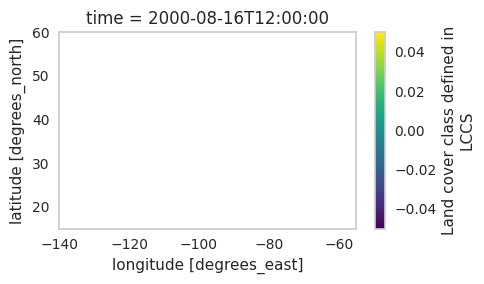

In [30]:


#ds_na = ds_na.where(ds_merged["transcom_regions"]==2)

import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
ds_na["lccs_class"].isel(time=15).plot()
plt.tight_layout()



In [25]:
df_train = ds_na.to_dataframe()
df_train

bio_flux_opt  transcom_regions  \
longitude latitude time                                                  
-139.5    15.5     2000-01-01 00:00:00           NaN              14.0   
                   2000-01-16 12:00:00           0.0              14.0   
                   2000-02-01 00:00:00           NaN              14.0   
                   2000-02-15 12:00:00           0.0              14.0   
                   2000-03-01 00:00:00           NaN              14.0   
...                                              ...               ...   
-55.5     59.5     2019-10-16 12:00:00           0.0              16.0   
                   2019-11-01 00:00:00           NaN              16.0   
                   2019-11-16 00:00:00           0.0              16.0   
                   2019-12-01 00:00:00           NaN              16.0   
                   2019-12-16 12:00:00           0.0              16.0   

                                        biomass  spei  NDVI  NIRv         d2m  \
longitude latitude time                                                         
-139.5    15.5     2000-01-01 00:00:00      NaN   NaN   NaN   NaN  292.766571   
                   2000-01-16 12:00:00      NaN   NaN   NaN   NaN         NaN   
                   2000-02-01 00:00:00      NaN   NaN   NaN   NaN  291.571198   
                   2000-02-15 12:00:00      NaN   NaN   NaN   NaN         NaN   
                   2000-03-01 00:00:00      NaN   NaN   NaN   NaN  290.706635   
...                                         ...   ...   ...   ...         ...   
-55.5     59.5     2019-10-16 12:00:00      NaN   NaN   NaN   NaN         NaN   
                   2019-11-01 00:00:00      NaN   NaN   NaN   NaN  271.846222   
                   2019-11-16 00:00:00      NaN   NaN   NaN   NaN         NaN   
                   2019-12-01 00:00:00      NaN   NaN   NaN   NaN  268.132172   
                   2019-12-16 12:00:00      NaN   NaN   NaN   NaN         NaN   

                                             mslhf      msshf             sp  \
longitude latitude time                                                        
-139.5    15.5     2000-01-01 00:00:00 -148.244354 -11.788261  101528.492188   
                   2000-01-16 12:00:00         NaN        NaN            NaN   
                   2000-02-01 00:00:00 -162.336075  -9.084946  101715.867188   
                   2000-02-15 12:00:00         NaN        NaN            NaN   
                   2000-03-01 00:00:00 -192.907013 -11.852631  101657.953125   
...                                            ...        ...            ...   
-55.5     59.5     2019-10-16 12:00:00         NaN        NaN            NaN   
                   2019-11-01 00:00:00  -99.596176 -55.635628  100492.273438   
                   2019-11-16 00:00:00         NaN        NaN            NaN   
                   2019-12-01 00:00:00 -119.835022 -84.748451  100273.085938   
                   2019-12-16 12:00:00         NaN        NaN            NaN   

                                        ...  skt  stl1  stl2  stl3  stl4  \
longitude latitude time                 ...                                
-139.5    15.5     2000-01-01 00:00:00  ...  NaN   NaN   NaN   NaN   NaN   
                   2000-01-16 12:00:00  ...  NaN   NaN   NaN   NaN   NaN   
                   2000-02-01 00:00:00  ...  NaN   NaN   NaN   NaN   NaN   
                   2000-02-15 12:00:00  ...  NaN   NaN   NaN   NaN   NaN   
                   2000-03-01 00:00:00  ...  NaN   NaN   NaN   NaN   NaN   
...                                     ...  ...   ...   ...   ...   ...   
-55.5     59.5     2019-10-16 12:00:00  ...  NaN   NaN   NaN   NaN   NaN   
                   2019-11-01 00:00:00  ...  NaN   NaN   NaN   NaN   NaN   
                   2019-11-16 00:00:00  ...  NaN   NaN   NaN   NaN   NaN   
                   2019-12-01 00:00:00  ...  NaN   NaN   NaN   NaN   NaN   
                   2019-12-16 12:00:00  ...  NaN   NaN   NaN   NaN   N